<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/02_DeepLearning_Task_2__Week_6_RNN%2CLSTM%2C_GRU_DeteksiSarkasme_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.9 MB/s eta 0:00:00


In [12]:
import tensorflow as tf
import keras_tuner as kt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##Tensorflow

###Data Preparation

In [28]:
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
df = pd.read_json(url, lines=True)

In [29]:
df['headline'] = df['headline'].astype(str).str.lower()
df['is_sarcastic'] = df['is_sarcastic'].astype(int)

texts = df['headline'].values
labels = df['is_sarcastic'].values

In [30]:
num_words = 10000
maxlen = 200

In [31]:
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x = pad_sequences(sequences, maxlen=maxlen)
y = labels

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

###RNN

Pemodelan RNN

In [24]:
def rnn_model(hp):
    model = Sequential()
    model.add(Embedding(num_words,hp.Choice('embedding_dim', [64, 128, 256]),input_length=maxlen))
    model.add(SimpleRNN(units=hp.Int('rnn_units', min_value=32, max_value=256, step=32),dropout=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_units', 32, 128, step=32),activation='relu'))
    model.add(Dropout(rate=hp.Float('dense_dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4])),loss='binary_crossentropy', metrics=['accuracy'])
    return model

Optimzer

In [25]:
tuner = kt.RandomSearch(
    rnn_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='rnn_sarcasm'
)
tuner.search(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Reloading Tuner from tuner_dir/rnn_sarcasm/tuner0.json


In [26]:
rnn_model = tuner.get_best_models(num_models=1)[0]
rnn_optimizer = rnn_model.optimizer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training data 😀😀😀

In [27]:
def train_rnn_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=64):
    model.compile(optimizer=rnn_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)
    ]

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

# Train best model dari tuning
trained_rnn, rnn_history = train_rnn_model(rnn_model, x_train, y_train, x_test, y_test)

# Evaluate
loss, accuracy = trained_rnn.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.9253 - loss: 0.1969 - val_accuracy: 0.8531 - val_loss: 0.3679 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9781 - loss: 0.0657 - val_accuracy: 0.8371 - val_loss: 0.5227 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9933 - loss: 0.0195 - val_accuracy: 0.8388 - val_loss: 0.7098 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.8399 - val_loss: 0.7732 - learning_rate: 5.0000e-04
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8586 - loss: 0.3535

Test Accuracy: 85.31%
Test Loss: 0.3679


###LSTM

Modeling data LSTM

In [33]:
def lstm_model(hp):
    model = Sequential()
    model.add(Embedding(num_words,hp.Choice('embedding_dim', [64, 128, 256]),input_length=maxlen))
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),dropout=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=hp.Choice('lr', [1e-3, 1e-4])),loss='binary_crossentropy', metrics=['accuracy'])
    return model

Optimizer

In [34]:
tuner_lstm = kt.RandomSearch(
    lstm_model,
    objective='val_accuracy',
    max_trials=3,
    directory='tuner_dir',
    project_name='lstm_sarcasm'
)

tuner_lstm.search(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Reloading Tuner from tuner_dir/lstm_sarcasm/tuner0.json


In [35]:
best_lstm_model = tuner_lstm.get_best_models(num_models=1)[0]
lstm_optimizer = best_lstm_model.optimizer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training data 😀😀😀

In [36]:
def train_lstm_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=64):
    model.compile(optimizer=lstm_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)
    ]

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

# Train the model
print("\nTraining LSTM model...")
trained_lstm, lstm_history = train_lstm_model(best_lstm_model, x_train, y_train, x_test, y_test)


Training LSTM model...
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9562 - loss: 0.1216 - val_accuracy: 0.8615 - val_loss: 0.3559 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9688 - loss: 0.0848 - val_accuracy: 0.8540 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9825 - loss: 0.0520 - val_accuracy: 0.8456 - val_loss: 0.5472 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9905 - loss: 0.0292 - val_accuracy: 0.8474 - val_loss: 0.6233 - learning_rate: 5.0000e-04


###GRU

Modeling data GRU

In [18]:
def gru_model(hp):
    vocab_size = num_words  # Assuming num_words is your vocabulary size
    embedding_dim = hp.Choice('embedding_dim', [64, 128, 256]) # Using hp for embedding_dim

    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
    model.add(GRU(
        units=hp.Int('gru_units', min_value=32, max_value=256, step=32),
        dropout=hp.Float('dropout', 0.2, 0.5, step=0.1)
    ))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

Optimizer

In [19]:
tuner_gru = kt.RandomSearch(
    gru_model,
    objective='val_accuracy',
    max_trials=3,
    directory='tuner_dir',
    project_name='gru_sarcasm'
)

tuner_gru.search(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Reloading Tuner from tuner_dir/gru_sarcasm/tuner0.json


In [20]:
best_gru_model = tuner_gru.get_best_models(num_models=1)[0]
gru_optimizer = best_gru_model.optimizer

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training data 😀😀😀

In [21]:
def train_gru_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=64):
    model.compile(
        optimizer=gru_optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1),
        ModelCheckpoint('best_gru_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
    ]

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1,
    )

    return model, history
    # 4. Training & evaluation
print("\nTraining GRU model...")
trained_gru, gru_history = train_gru_model(best_gru_model, x_train, y_train, x_test, y_test)
loss, accuracy, precision, recall = trained_gru.evaluate(x_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {precision * 100:.2f}%")
print(f"Test Recall: {recall * 100:.2f}%")



Training GRU model...
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9333 - loss: 0.1756 - precision: 0.9261 - recall: 0.9195 - val_accuracy: 0.8583 - val_loss: 0.3514 - val_precision: 0.8620 - val_recall: 0.8065 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9548 - loss: 0.1274 - precision: 0.9528 - recall: 0.9441 - val_accuracy: 0.8566 - val_loss: 0.4051 - val_precision: 0.8379 - val_recall: 0.8350 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9695 - loss: 0.0902 - precision: 0.9687 - recall: 0.9613 - val_accuracy: 0.8536 - val_loss: 0.4483 - val_precision: 0.8457 - val_recall: 0.8154 - learning_rate: 0.0010
Epoch 4/10
332/334 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9781 - loss: 0.0654 - precision: 0.9784 - recall: 0.9717
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
334/334 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9781 - loss: 0.0

###Evaluasi dari RNN, LSTM, dan GRU

Modeling evaluasi untuk RNN, LSTM, dan GRU

In [37]:
def evaluate_model(model, x_test, y_test, model_name):
    y_prob = model.predict(x_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    print(f"\n{model_name} Evaluation:")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.colorbar()
    plt.xticks([0,1], ['Negative', 'Positive'])
    plt.yticks([0,1], ['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i][j]), ha='center', va='center', color='white' if cm[i,j] > cm.max()/2 else 'black')

    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

perbandingan antara RNN, LSTM, GRU

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

RNN Evaluation:
Accuracy: 0.8531
Precision: 0.8357
Recall: 0.8282
F1 Score: 0.8319
ROC AUC: 0.9251

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87      2996
    Positive       0.84      0.83      0.83      2346

    accuracy                           0.85      5342
   macro avg       0.85      0.85      0.85      5342
weighted avg       0.85      0.85      0.85      5342



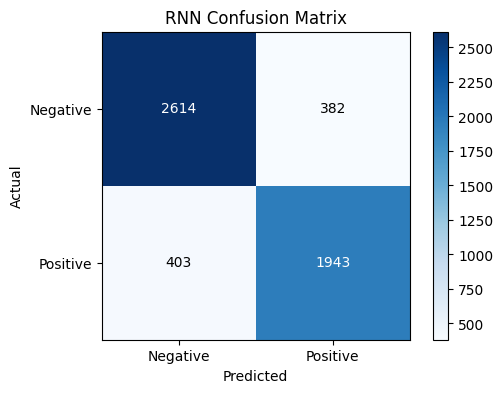

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

LSTM Evaluation:
Accuracy: 0.8585
Precision: 0.8463
Recall: 0.8282
F1 Score: 0.8371
ROC AUC: 0.9345

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.87      2996
    Positive       0.85      0.83      0.84      2346

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



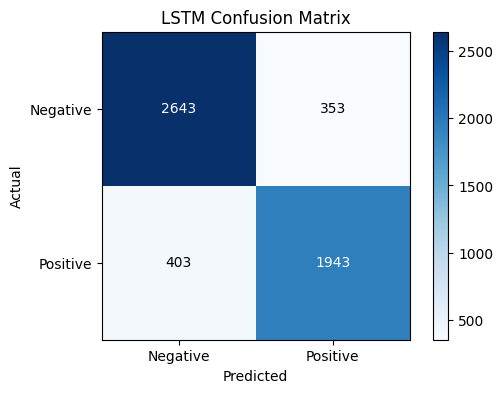

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

GRU Evaluation:
Accuracy: 0.8592
Precision: 0.8600
Recall: 0.8116
F1 Score: 0.8351
ROC AUC: 0.9355

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      2996
    Positive       0.86      0.81      0.84      2346

    accuracy                           0.86      5342
   macro avg       0.86      0.85      0.86      5342
weighted avg       0.86      0.86      0.86      5342



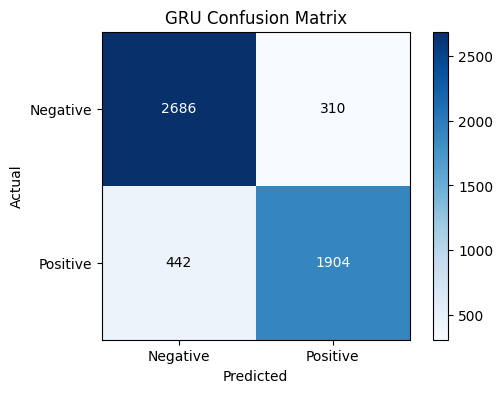

In [39]:
rnn_results = evaluate_model(rnn_model, x_test, y_test, 'RNN')
lstm_results = evaluate_model(best_lstm_model, x_test, y_test, 'LSTM')
gru_results = evaluate_model(best_gru_model, x_test, y_test, 'GRU')

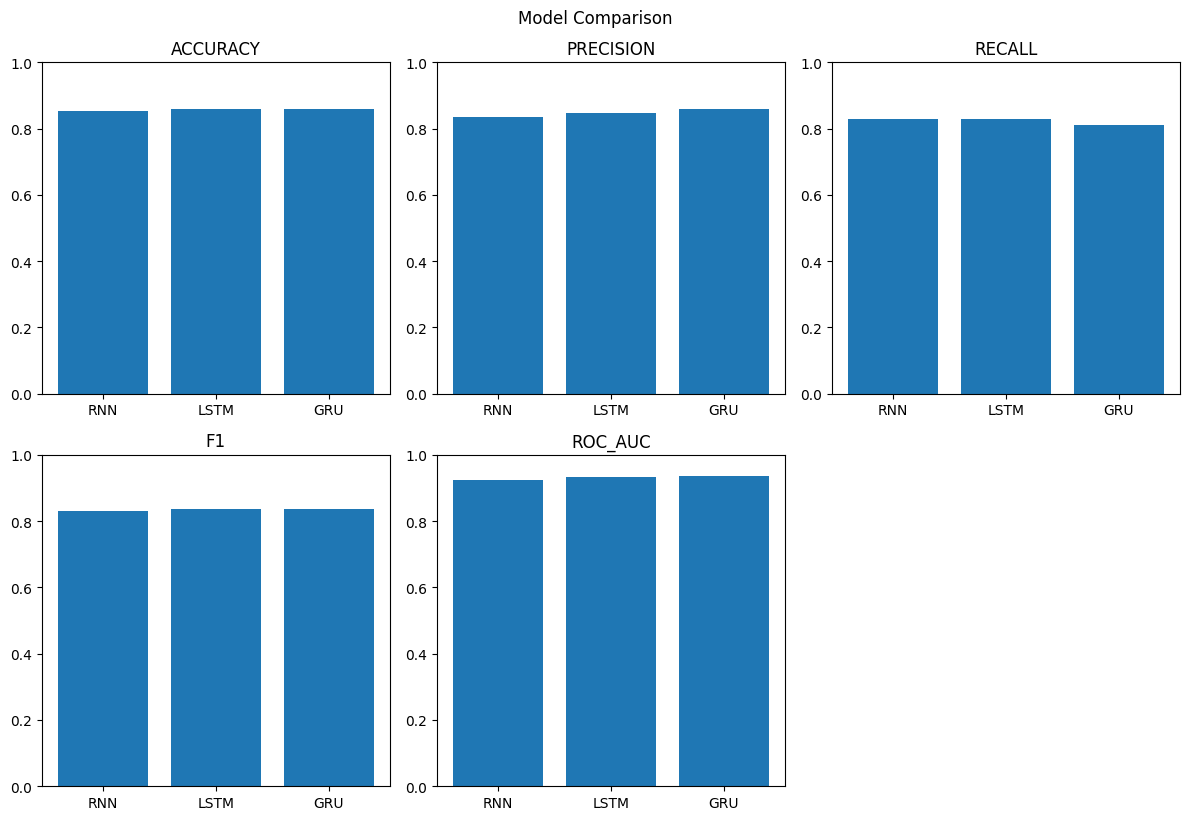

In [40]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results = {'RNN': rnn_results, 'LSTM': lstm_results, 'GRU': gru_results}

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    plt.bar(results.keys(), [results[model][metric] for model in results])
    plt.title(metric.upper())
    plt.ylim(0, 1)
plt.tight_layout()
plt.suptitle('Model Comparison', y=1.02)
plt.show()

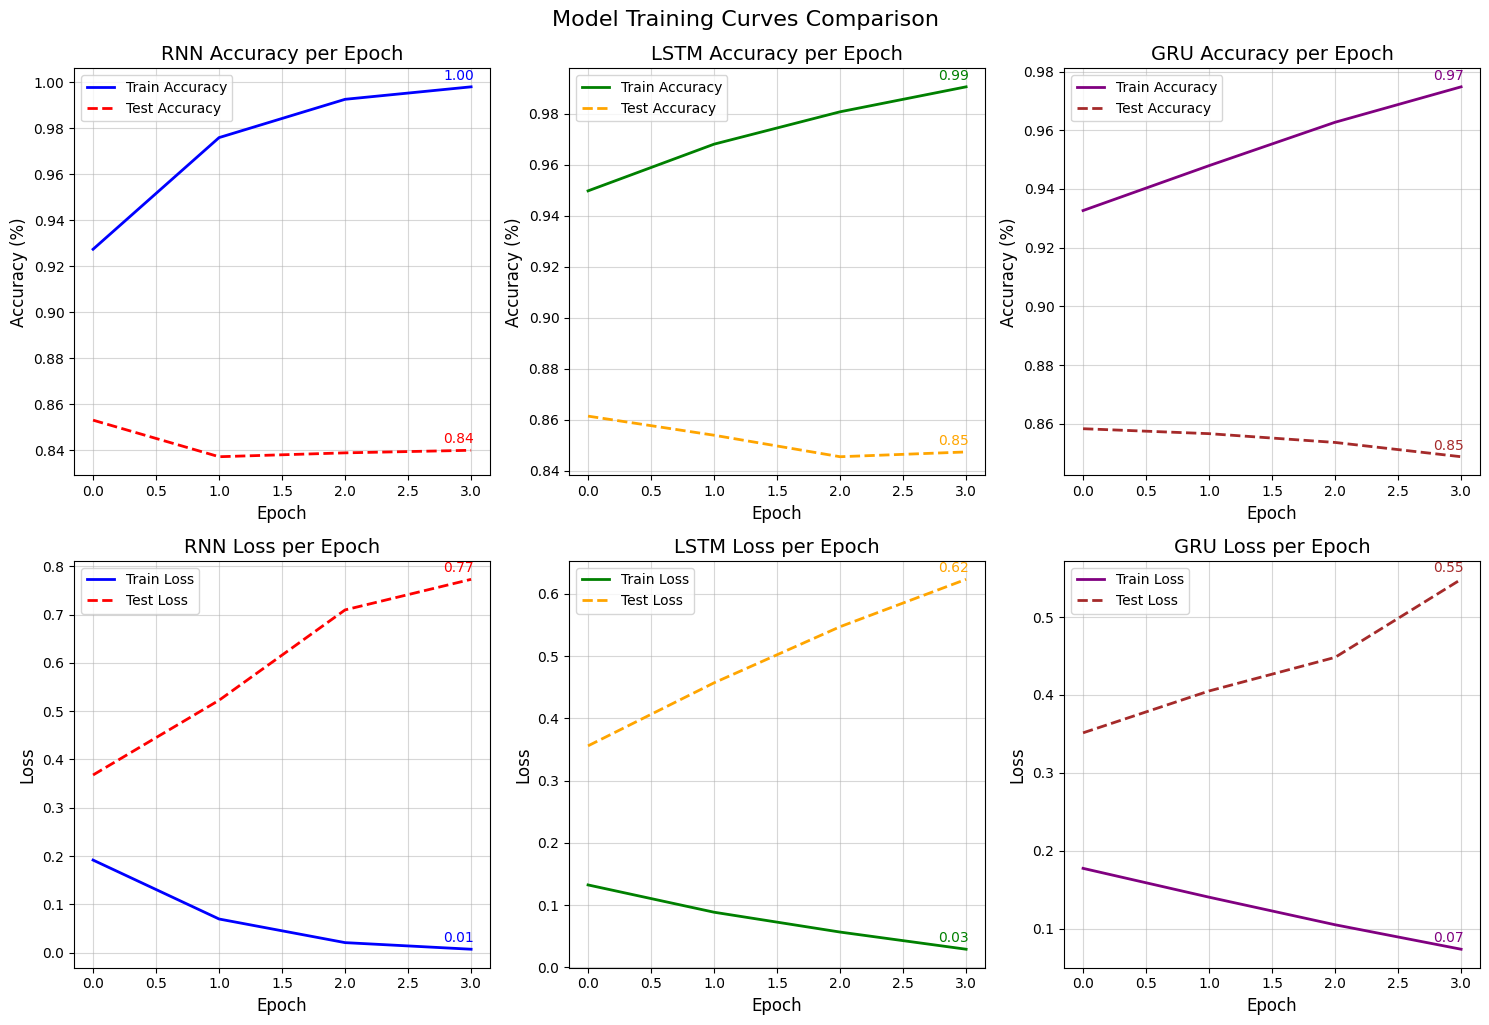

In [41]:
plt.figure(figsize=(15, 10))

# RNN Training Curves
plt.subplot(2, 3, 1)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(rnn_history.history['val_accuracy'], '--', label='Test Accuracy', color='red', linewidth=2)
plt.title('RNN Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.annotate(f"{rnn_history.history['accuracy'][-1]:.2f}",
             xy=(len(rnn_history.history['accuracy']) - 1, rnn_history.history['accuracy'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='blue')
plt.annotate(f"{rnn_history.history['val_accuracy'][-1]:.2f}",
             xy=(len(rnn_history.history['val_accuracy']) - 1, rnn_history.history['val_accuracy'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='red')

plt.subplot(2, 3, 4)
plt.plot(rnn_history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(rnn_history.history['val_loss'], '--', label='Test Loss', color='red', linewidth=2)
plt.title('RNN Loss per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.annotate(f"{rnn_history.history['loss'][-1]:.2f}",
             xy=(len(rnn_history.history['loss']) - 1, rnn_history.history['loss'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='blue')
plt.annotate(f"{rnn_history.history['val_loss'][-1]:.2f}",
             xy=(len(rnn_history.history['val_loss']) - 1, rnn_history.history['val_loss'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='red')

# LSTM Training Curves
plt.subplot(2, 3, 2)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy', color='green', linewidth=2)
plt.plot(lstm_history.history['val_accuracy'], '--', label='Test Accuracy', color='orange', linewidth=2)
plt.title('LSTM Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.annotate(f"{lstm_history.history['accuracy'][-1]:.2f}",
             xy=(len(lstm_history.history['accuracy']) - 1, lstm_history.history['accuracy'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='green')
plt.annotate(f"{lstm_history.history['val_accuracy'][-1]:.2f}",
             xy=(len(lstm_history.history['val_accuracy']) - 1, lstm_history.history['val_accuracy'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='orange')

plt.subplot(2, 3, 5)
plt.plot(lstm_history.history['loss'], label='Train Loss', color='green', linewidth=2)
plt.plot(lstm_history.history['val_loss'], '--', label='Test Loss', color='orange', linewidth=2)
plt.title('LSTM Loss per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.annotate(f"{lstm_history.history['loss'][-1]:.2f}",
             xy=(len(lstm_history.history['loss']) - 1, lstm_history.history['loss'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='green')
plt.annotate(f"{lstm_history.history['val_loss'][-1]:.2f}",
             xy=(len(lstm_history.history['val_loss']) - 1, lstm_history.history['val_loss'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='orange')

# GRU Training Curves
plt.subplot(2, 3, 3)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy', color='purple', linewidth=2)
plt.plot(gru_history.history['val_accuracy'], '--', label='Test Accuracy', color='brown', linewidth=2)
plt.title('GRU Accuracy per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.annotate(f"{gru_history.history['accuracy'][-1]:.2f}",
             xy=(len(gru_history.history['accuracy']) - 1, gru_history.history['accuracy'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='purple')
plt.annotate(f"{gru_history.history['val_accuracy'][-1]:.2f}",
             xy=(len(gru_history.history['val_accuracy']) - 1, gru_history.history['val_accuracy'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='brown')

plt.subplot(2, 3, 6)
plt.plot(gru_history.history['loss'], label='Train Loss', color='purple', linewidth=2)
plt.plot(gru_history.history['val_loss'], '--', label='Test Loss', color='brown', linewidth=2)
plt.title('GRU Loss per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.5)
plt.annotate(f"{gru_history.history['loss'][-1]:.2f}",
             xy=(len(gru_history.history['loss']) - 1, gru_history.history['loss'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='purple')
plt.annotate(f"{gru_history.history['val_loss'][-1]:.2f}",
             xy=(len(gru_history.history['val_loss']) - 1, gru_history.history['val_loss'][-1]),
             xytext=(-20, 5), textcoords='offset points', fontsize=10, color='brown')

plt.tight_layout()
plt.suptitle('Model Training Curves Comparison', fontsize=16, y=1.02)
plt.show()